## Data Preprocessing

In [ ]:
#loading & cleaning the data
# In this code we used 2000 dataset 
import pandas as pd
import numpy as np

#loading the file path
file_path = r"F:\programming\machine learning\2000 data.txt"

#read lines & include the one that starts & end with | -> rows
with open(file_path, 'r', encoding='utf-8') as file:
    lines = [line.strip() for line in file if line.strip().startswith('|')]

#parse the table content
rows = [line.split('|')[1:-1] for line in lines]  #remove outer borders
rows = [[cell.strip() for cell in row] for row in rows] #stripping whitespace around the cells

#extracing header(1st row) & data(the rest)
header = rows[0]
data = rows[1:]

#creating DataFrame & droping the first column ("Circuit Number")
df = pd.DataFrame(data, columns=header)
data = df.iloc[:, 1:]

#converting numeric features to float
for col in data.columns[:-1]:  #all except the simulator name (the last one)
    #errors='coerce': if any value can't be converted to a number, it'll be NaN
    data[col] = pd.to_numeric(data[col], errors='coerce')
data.dropna(inplace=True) #droping any rows with invalid data (NaN)

#extracting features & labels
X = data.iloc[:, :-1]
y = data.iloc[:, -1]

#getting the top 10 simulators (at least 2 samples) for cheking
sim_counts = y.value_counts()
top_10_simulators = sim_counts[sim_counts >= 2].head(10).index

mask = y.isin(top_10_simulators) #creating a boolean mask(T/F) indicating which rows in y belong to the top 10 simulators
X = X[mask].reset_index(drop=True)
y = y[mask].reset_index(drop=True)

print(" Top 10 simulators selected:", list(top_10_simulators))



 Top 10 simulators selected: ['ibmq_sherbrooke', 'ibmq_prague', 'ibmq_quebec', 'ibmq_marrakesh', 'ibmq_sydney', 'ibmq_peekskill', 'ibmq_singapore', 'ibmq_manhattan', 'ibmq_washington', 'ibmq_poughkeepsie']


C:\Users\Sajjad\AppData\Local\Temp\ipykernel_3896\2910926389.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col] = pd.to_numeric(data[col], errors='coerce')
C:\Users\Sajjad\AppData\Local\Temp\ipykernel_3896\2910926389.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True) #droping any rows with invalid data (NaN)


In [7]:
#Encoding labels

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split


#converting simulator names to numbers
le = LabelEncoder()
y_encoded = le.fit_transform(y)

#showing the transformation
print("Class mapping:")
for cls, code in zip(le.classes_, le.transform(le.classes_)):
    print(f"{cls} → {code}")
y=y_encoded


Class mapping:
ibmq_manhattan → 0
ibmq_marrakesh → 1
ibmq_peekskill → 2
ibmq_poughkeepsie → 3
ibmq_prague → 4
ibmq_quebec → 5
ibmq_sherbrooke → 6
ibmq_singapore → 7
ibmq_sydney → 8
ibmq_washington → 9


In [8]:
#train test splitting

X=np.array(X)
Y=np.array(y)
print(len(X),len(Y))
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3)

print("Training samples:", len(X_train))
print("Test samples:", len(X_test))

1381 1381
Training samples: 966
Test samples: 415


In [9]:
#feature scaling (standardize)

from sklearn.preprocessing import StandardScaler

#initialize the scaler
scaler = StandardScaler()

#fitting the scaler on training data and transform it
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

"""the scaling ensures that all features have a mean of 0 and a standard deviation of 1, 
which can help improve the performance of ML models, especially those sensitive to feature scaling
(like SGDClassifier, KNN, SVC)."""

'the scaling ensures that all features have a mean of 0 and a standard deviation of 1, \nwhich can help improve the performance of ML models, especially those sensitive to feature scaling\n(like SGDClassifier, KNN, SVC).'

## GaussianNB

In [10]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report

#training the model
gnb = GaussianNB()
gnb.fit(X_train_scaled, y_train)

#predict
y_pred = gnb.predict(X_test_scaled)

#evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))


Accuracy: 0.12530120481927712


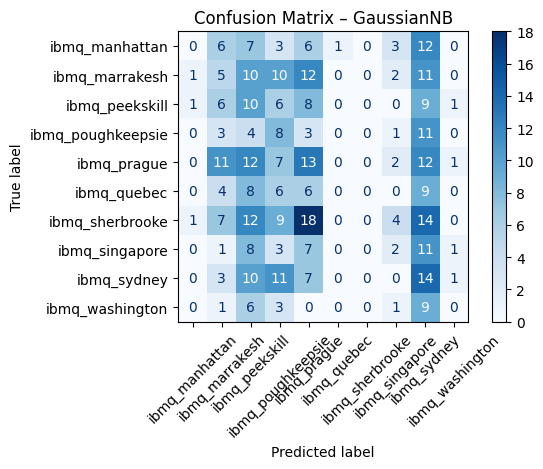

In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

#generating confusion matrix
cm = confusion_matrix(y_test, y_pred)

#displaying with class labels (from LabelEncoder)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap='Blues', xticks_rotation=45)

plt.title("Confusion Matrix – GaussianNB")
plt.tight_layout()
plt.show()


## SGDClassifier

In [12]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, classification_report

# 1️⃣ Scale features (fit on train, transform on both)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# 2️⃣ Initialize SGDClassifier for logistic regression
sgd_clf = SGDClassifier(
    loss='log_loss',    # logistic regression objective  (use 'log' if scikit‑learn < 1.1)
    penalty='l2',       # 'l2', 'l1', or 'elasticnet' are available
    alpha=.1,         # regularization strength (λ); tune via CV
    max_iter=1000,      # iterations (epochs) over the data
    learning_rate='optimal',  # default; other options: 'adaptive', 'invscaling', 'constant'
    early_stopping=False,      # stops when validation score doesn’t improve
)

# 3️⃣ Train the model
sgd_clf.fit(X_train_scaled, y_train)

# 4️⃣ Predict and evaluate
y_pred_sgd = sgd_clf.predict(X_test_scaled)

accuracy_sgd = accuracy_score(y_test, y_pred_sgd)
print(f"SGDClassifier (Logistic Regression) – Test Accuracy: {accuracy_sgd:.2f}\n")



SGDClassifier (Logistic Regression) – Test Accuracy: 0.14



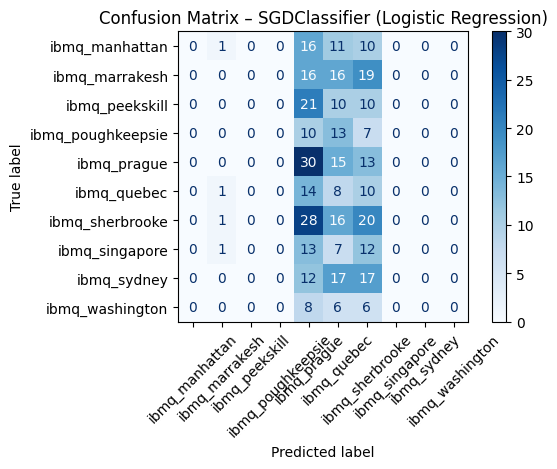

In [13]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred_sgd)

# Display with class labels from LabelEncoder
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap='Blues', xticks_rotation=45)

plt.title("Confusion Matrix – SGDClassifier (Logistic Regression)")
plt.tight_layout()
plt.show()


## RandomForestClassifier

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

# (Optional) Scale features for consistency (trees don't require it)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# Train Random Forest
rf_clf = RandomForestClassifier(
    n_estimators=200,
    max_depth=100,             # not too deep, not too shallow
    min_samples_split=4,
    min_samples_leaf=2,
    random_state=42
)

rf_clf.fit(X_train_scaled, y_train)

# Predict and report accuracy
y_pred_rf = rf_clf.predict(X_test_scaled)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest – Accuracy: {accuracy_rf:.4f}")


Random Forest – Accuracy: 0.1373


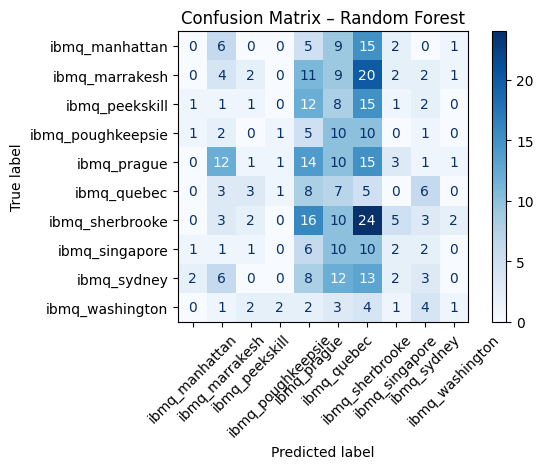

In [15]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred_rf)

# Display using label encoder classes
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap='Blues', xticks_rotation=45)

plt.title("Confusion Matrix – Random Forest")
plt.tight_layout()
plt.show()


## HistGradientBoostingClassifier

In [16]:
# Import necessary modules
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report

# No need to scale the data — HGBT handles raw features well
# 1️⃣ Initialize the model
hgb_clf = HistGradientBoostingClassifier(
    max_iter=100,          # Number of boosting iterations (trees)
    learning_rate=0.1,     # Shrinkage rate
    max_depth=None,        # Let it grow as needed (or set a limit for regularization)
    random_state=42
)

# 2️⃣ Train the model
hgb_clf.fit(X_train, y_train)

# 3️⃣ Predict and evaluate
y_pred_hgb = hgb_clf.predict(X_test)

accuracy_hgb = accuracy_score(y_test, y_pred_hgb)
print(f"HistGradientBoostingClassifier – Test Accuracy: {accuracy_hgb:.2f}\n")


HistGradientBoostingClassifier – Test Accuracy: 0.13



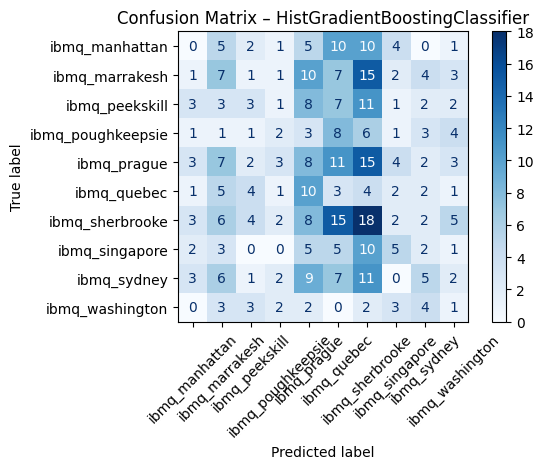

In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred_hgb)

# Display with class labels (from LabelEncoder)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap='Blues', xticks_rotation=45)

plt.title("Confusion Matrix – HistGradientBoostingClassifier")
plt.tight_layout()
plt.show()


## KNeighborsClassifier

In [18]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

# Scale features (KNN is distance-based — scaling is critical)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# Train KNN (default: 5 neighbors)
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train_scaled, y_train)

# Predict and report accuracy
y_pred_knn = knn.predict(X_test_scaled)
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print(f"K-Nearest Neighbors – Accuracy: {accuracy_knn:.4f}")


K-Nearest Neighbors – Accuracy: 0.1036


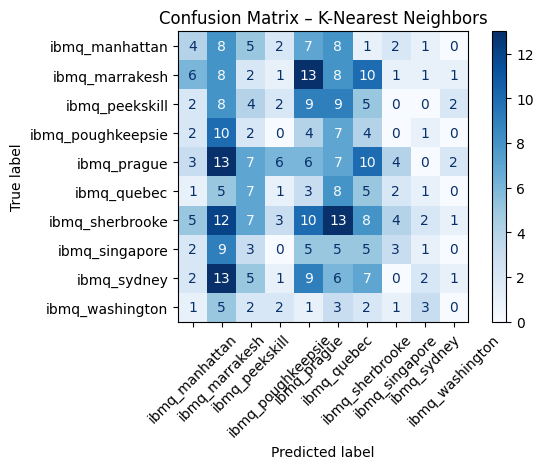

In [19]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred_knn)

# Display matrix using class labels from label encoder
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap='Blues', xticks_rotation=45)

plt.title("Confusion Matrix – K-Nearest Neighbors")
plt.tight_layout()
plt.show()


## DecisionTreeClassifier

In [20]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

# (Optional) Scale features for consistency (not required for trees)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# Train Decision Tree
dt_clf = DecisionTreeClassifier(random_state=42)
dt_clf.fit(X_train_scaled, y_train)

# Predict and report accuracy
y_pred_dt = dt_clf.predict(X_test_scaled)
accuracy_dt = accuracy_score(y_test, y_pred_dt)
print(f"Decision Tree – Accuracy: {accuracy_dt:.4f}")


Decision Tree – Accuracy: 0.1229


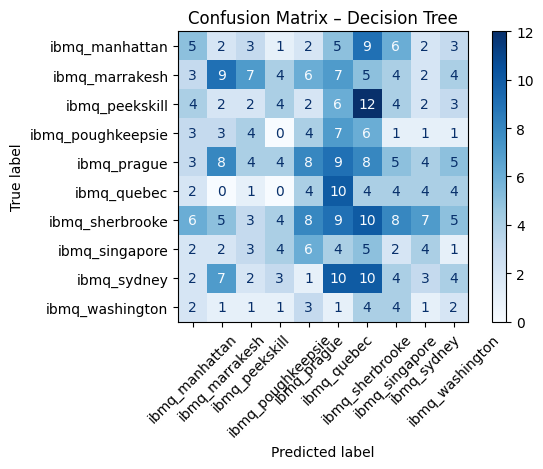

In [21]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred_dt)

# Display with class labels (from LabelEncoder)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap='Blues', xticks_rotation=45)

plt.title("Confusion Matrix – Decision Tree")
plt.tight_layout()
plt.show()


## BaggingClassifier

In [22]:
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import accuracy_score

# Train BaggingClassifier (default base_estimator is DecisionTreeClassifier)
bag_clf = BaggingClassifier(random_state=42)
bag_clf.fit(X_train, y_train)

# Predict and print accuracy
y_pred_bag = bag_clf.predict(X_test)
accuracy_bag = accuracy_score(y_test, y_pred_bag)
print(f"BaggingClassifier – Test Accuracy: {accuracy_bag:.2f}")

BaggingClassifier – Test Accuracy: 0.12


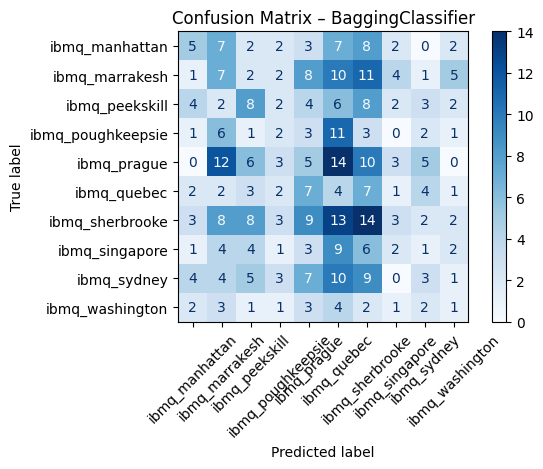

In [23]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred_bag)

# Display using label encoder (if applied)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap='Blues', xticks_rotation=45)

plt.title("Confusion Matrix – BaggingClassifier")
plt.tight_layout()
plt.show()


## AdaBoostClassifier

In [24]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score

# Train AdaBoostClassifier
ada_clf = AdaBoostClassifier(random_state=42)
ada_clf.fit(X_train, y_train)

# Predict and print accuracy
y_pred_ada = ada_clf.predict(X_test)
accuracy_ada = accuracy_score(y_test, y_pred_ada)
print(f"AdaBoostClassifier – Test Accuracy: {accuracy_ada:.2f}")

AdaBoostClassifier – Test Accuracy: 0.14


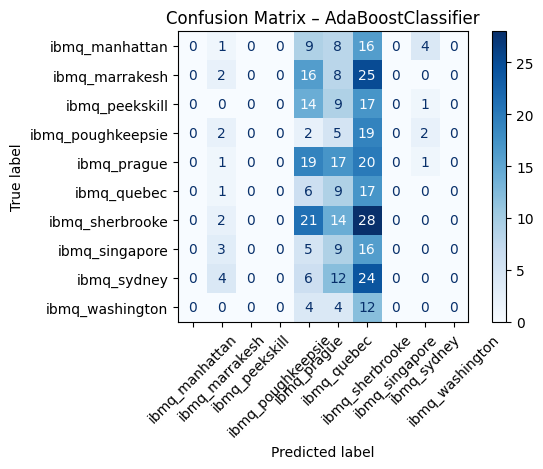

In [25]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred_ada)

# Display with class labels (if you used LabelEncoder)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap='Blues', xticks_rotation=45)

plt.title("Confusion Matrix – AdaBoostClassifier")
plt.tight_layout()
plt.show()


## SVC

In [26]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score

# Pipeline: scaling + SVC
svc_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC(kernel='rbf', random_state=42))
])

# Grid of hyperparameters
param_grid = {
    'svc__C': [0.1, 1, 10, 100],
    'svc__gamma': ['scale', 'auto', 0.01, 0.1, 1]
}

# Grid search with 5-fold cross-validation
grid_search = GridSearchCV(
    estimator=svc_pipeline,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

# Fit on training data
grid_search.fit(X_train, y_train)

# Best parameters and score
print(" Best Parameters:", grid_search.best_params_)
print(f" Best Cross-Validated Accuracy: {grid_search.best_score_:.4f}")

# Test set performance
y_pred = grid_search.best_estimator_.predict(X_test)
test_acc = accuracy_score(y_test, y_pred)
print(f" Test Set Accuracy with Best Params: {test_acc:.4f}")


 Best Parameters: {'svc__C': 1, 'svc__gamma': 'scale'}
 Best Cross-Validated Accuracy: 0.1781
 Test Set Accuracy with Best Params: 0.1494


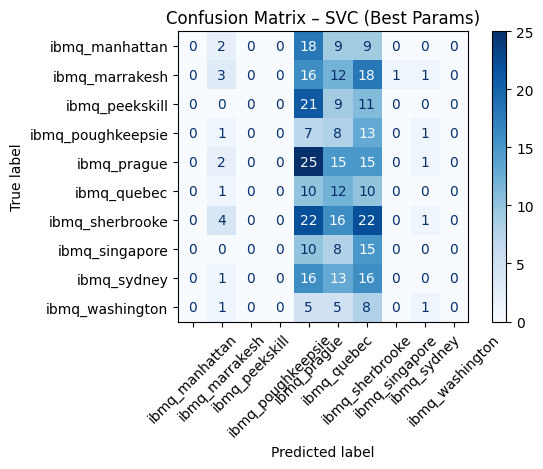

In [27]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict using best model
y_pred = grid_search.best_estimator_.predict(X_test)

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display with labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap='Blues', xticks_rotation=45)

plt.title("Confusion Matrix – SVC (Best Params)")
plt.tight_layout()
plt.show()
